In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud, STOPWORDS
from twython import Twython
import keys #twitter keys: APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import string
from collections import defaultdict

import gensim
from gensim import corpora


import requests

from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,twython,nltk,wordCloud,gensim

2017-01-08 

CPython 3.5.1
IPython 4.2.0

pandas 0.18.1
scipy 0.17.1
matplotlib 1.5.1
twython 3.4.0
nltk 3.2.1
wordCloud 1.2.1
gensim 0.13.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


C:\Anaconda3\lib\site-packages\gensim\utils.py:843: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# twython auth
twitter = Twython(keys.APP_KEY, keys.APP_SECRET,keys.OAUTH_TOKEN, keys.OAUTH_TOKEN_SECRET)
# init empty lists to save tweets and metadata
user_ids, user_names, texts , creation, retweets ,favorites,lenguage, retweet, retweet_from, in_reply, coordinates = ([] for i in range(11))
# get following IDs and NAMES (can get more info of users if needed!)
following_ids = [] # to save ids
following_names = {} # dictinary key:user_id, value: user_name
user_location = []
following = twitter.get_friends_ids()["ids"]
print("Number of following: ",len(following))

# get 200 tweets and metadata from each friend (can get more metadata if needed!)
for user_id in following:
    tweets200 = twitter.get_user_timeline(user_id=user_id,count=200)
    for t in tweets200:
        user_ids.append(user_id)
        #user_names.append(following_names[user_id])
        texts.append(t["text"])
        creation.append(t["created_at"])
        retweets.append(t["retweet_count"])
        favorites.append(t["favorite_count"])
        lenguage.append(t["lang"])
        #coordinates.append(t["coordinates"])
        in_reply.append(t['in_reply_to_screen_name'])
        retweet.append(('retweeted_status') in t)
        if ('retweeted_status') in t:
            retweet_from.append(t['retweeted_status']['user']['name'])
        else:
            retweet_from.append("N/A")
    #get user location
    user_location.append(twitter.show_user(user_id=user_id)["location"])
    
# create final DataFrame
mytweets = pd.DataFrame({'user_id':user_ids,#'user_name':user_names,
                         'text':texts ,'retweet': retweet, 'creation':creation,
                         'retweets':retweets , 'favorites':favorites, 
                         'lenguage':lenguage,'retweet_from': retweet_from,
                         'in_reply':in_reply})

mytweets["in_reply"] = mytweets["in_reply"].map(lambda x: "None" if x is None else x) # fix in_replay column None type to "None"

Number of following:  442


In [3]:
# Home many of all tweets are regular, tweeet, reply
def tweet_type(row):
    if row.retweet == True:
        return "retweet"
    elif row.in_reply == "None":
        return "reply"
    else:
        return "tweet"
# are there any replies and retweets?
a = mytweets.apply(tweet_type,1)

In [4]:
stop = stopwords.words('english') + stopwords.words('spanish')
other_stop = ['via','&amp;', 'now','one','thing','us', 'will',"it's",'it',"i'm","u","you","yet", "say"
             "much", "gt", "new", "us", "also","don't", ]
stop = set(stop + other_stop)
exclude = set(string.punctuation)
def clean_tweets (tweets_string, puntuation=True, lemmatize=False, sentiment=True):
    # gets a string with all tweets and remove RT, links and ids (start with @)
    lemma = WordNetLemmatizer()
    words_clean = " ".join([word.lower() for word in tweets_string.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    if not sentiment:
        words_clean = " ".join([i for i in words_clean.lower().split() if i not in stop])
    if puntuation:
        words_clean = "".join(ch for ch in words_clean if ch not in exclude)
    if lemmatize :    
            words_clean = " ".join(lemma.lemmatize(word) for word in words_clean.split() if type(word) is str)
    return words_clean
    
# words of ALL TWEETS
words = clean_tweets(' '.join(mytweets['text']), sentiment=False)
# words of ALL REGULAR TWEETS 
words_regular = clean_tweets(' '.join(mytweets[(mytweets["in_reply"]=="None") & (mytweets["retweet"]==False)].text),sentiment=False)
# words of ONLY RETWEETS
words_rt = clean_tweets(' '.join(mytweets[mytweets["retweet"] == True].text),sentiment=False)
# words of ONLY REPLIES
words_reply = clean_tweets(' '.join(mytweets[mytweets["in_reply"] != "None"].text),sentiment=False)

In [5]:
def leaders(xs, top=20):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

# location of followings
locations = leaders(user_location,1000) #all locations

list_add=[] # list of lists [localization, number_of_times, latitude, longitude]

for loc in locations:
    la=[loc[0], loc[1]]
    fix_add = loc[0].replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        coordinates = resp_json_payload['results'][0]['geometry']['location']
        la.append(str(coordinates['lat'])+" "+str(coordinates['lng']))
        list_add.append(la)
    except:
        continue
location_df = pd.DataFrame(list_add, columns=["location","count", "coordinates"])
location_plot = location_df.groupby("coordinates")["count"].sum()
location_plot.sort_values(inplace=True)

In [6]:
sa_train = pd.read_csv(".\\data\\Sentiment Analysis Dataset.csv",error_bad_lines=False)
x_sa = sa_train["SentimentText"]
y_sa = sa_train["Sentiment"]
del sa_train
x_sa_clean = x_sa.map(clean_tweets)
# vectorize (bag of words)
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(x_sa)
# fit the whole training set and pred for my tweets to check
lge = LogisticRegression(random_state=23, fit_intercept=True, C=0.5, class_weight='balanced')
# get Train and my data ready for the molel
x_unseen = vectorizer.transform(mytweets['text'].map(clean_tweets))
lge.fit(X, y_sa)
predictions_unseen = lge.predict(x_unseen)
prob_unseen = lge.predict_proba(x_unseen)
results = pd.DataFrame({'Prediction':predictions_unseen,'Prob':list(prob_unseen),'tweet':mytweets['text']})

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


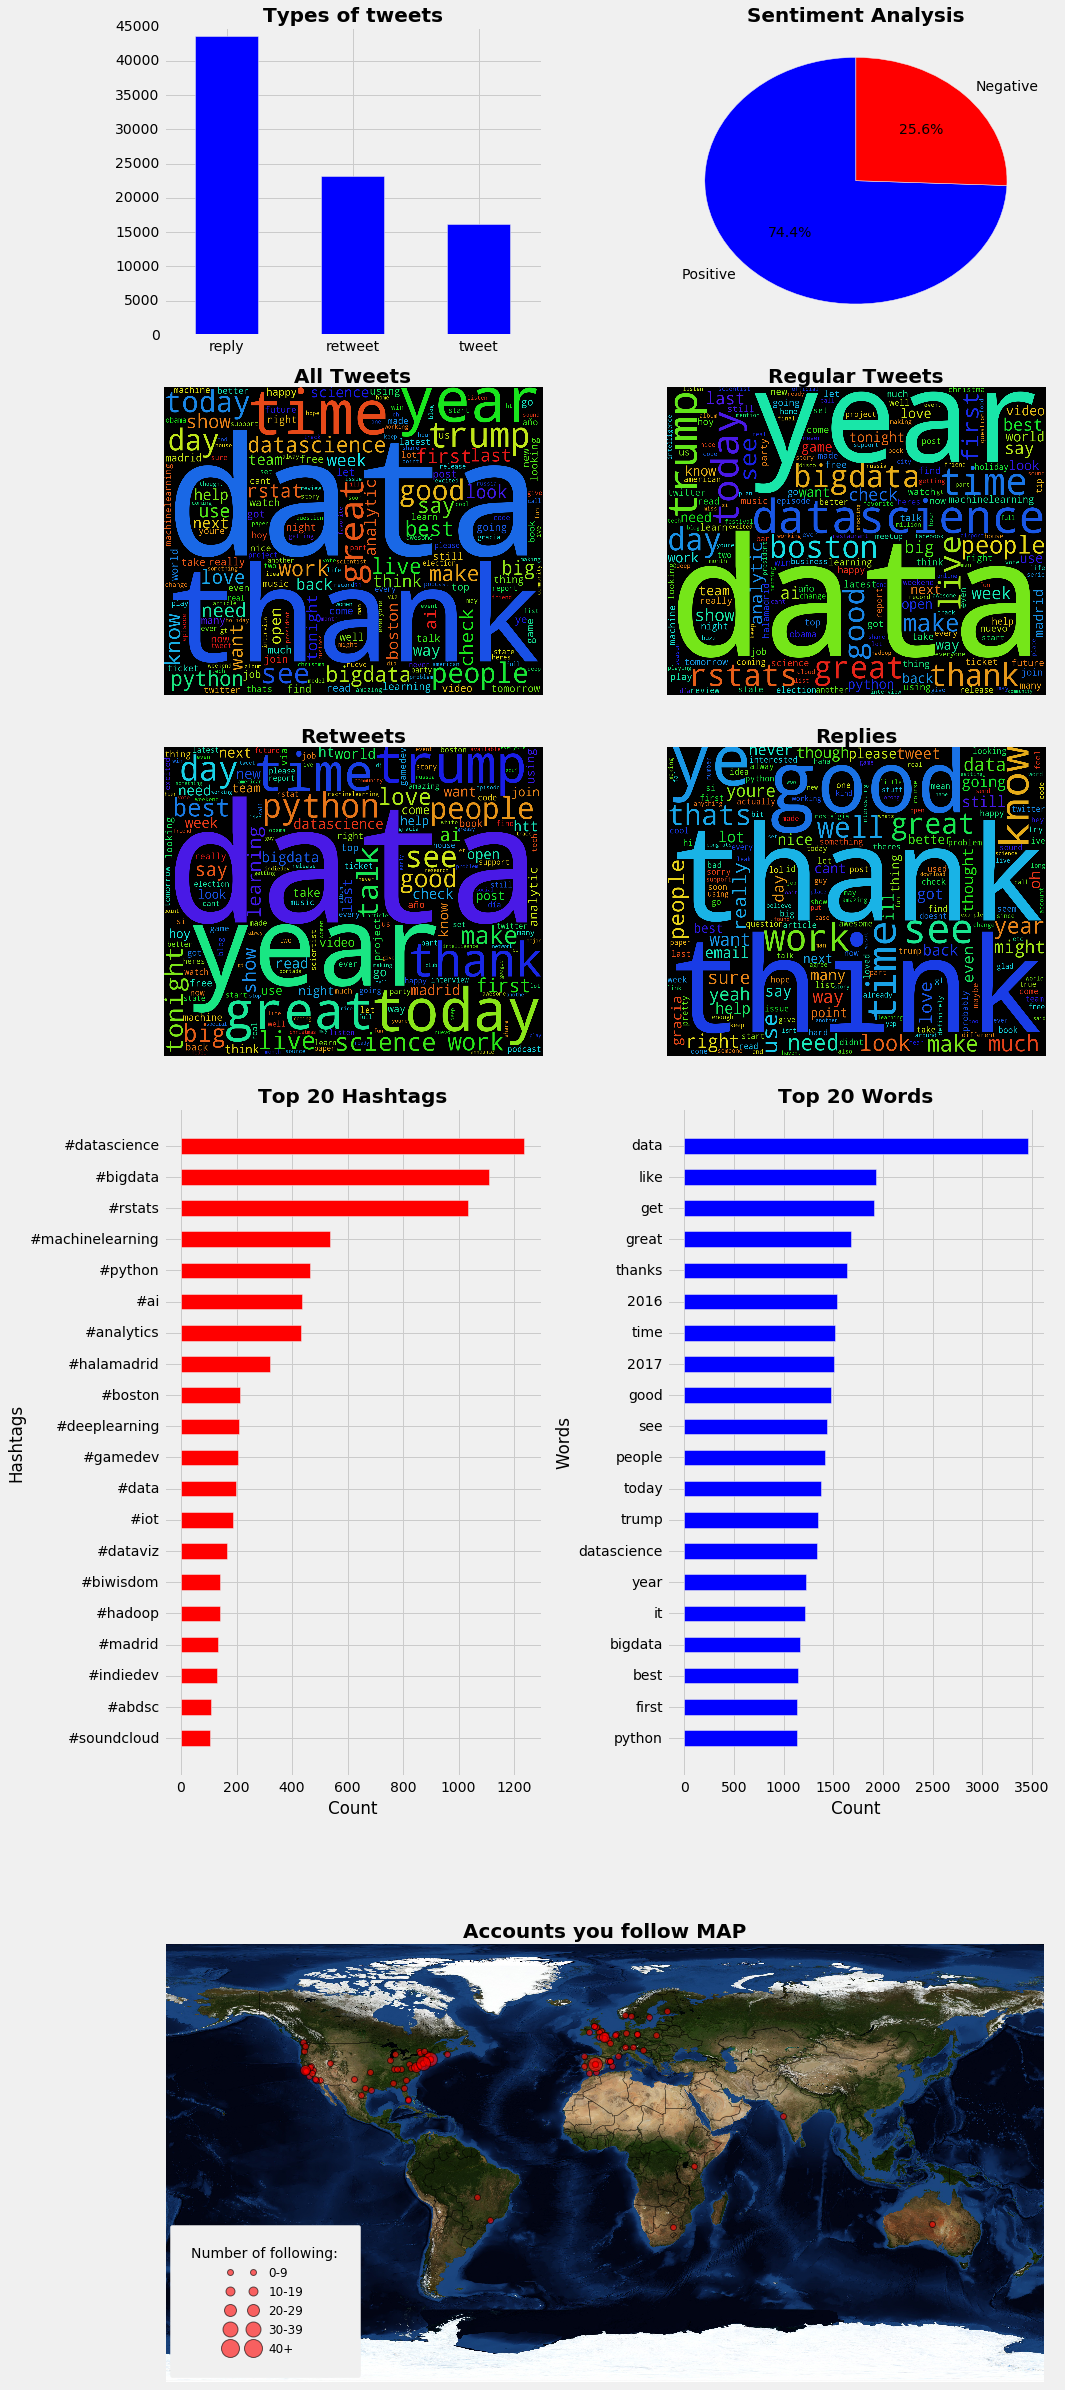

In [79]:
fig = plt.figure(figsize=(15,35))

#type of tweets
ax1 = plt.subplot2grid((7,2), (0,0))           
a.value_counts().plot(kind='bar', color='blue')
ax1.set_title("Types of tweets",fontweight = 'bold', size=20)
plt.xticks(rotation=0)

 
#sentiment
ax1 = plt.subplot2grid((7,2), (0,1)) 
plt.pie(results.Prediction.value_counts(), autopct='%1.1f%%', shadow=False, startangle=90, labels=["Positive","Negative"],colors=["blue","red"])
plt.title("Sentiment Analysis",fontweight = 'bold', size=20)


#worldcloud
title = ["All Tweets", "Regular Tweets","Retweets","Replies"]
place = [(1,0),(1,1),(2,0),(2,1)]
i=0 # for plot titles
for data in [words, words_regular, words_rt, words_reply]:  
    #generate wordcloud
    wordcloud = WordCloud(#stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(data)
    #print wordcloud
    plt.subplot2grid((7,2), place[i])
    plt.imshow(wordcloud,extent=[0,100,0,1], aspect='auto')
    #plt.extend(extent=[0,100,0,1], aspect='auto')
    plt.title(title[i],fontweight = 'bold', size=20)
    plt.axis('off')
    #plt.show()
    i+=1

    
# hastags
words = clean_tweets(' '.join(mytweets['text']), puntuation=False,sentiment=False) # puntuation is False so we don't delete hastags
top10hash = pd.DataFrame(leaders([x for x in words.split() if x[0]=='#' and x!='#rt']),columns=["hashtag", "count"])
#words
words = clean_tweets(' '.join(mytweets['text']),sentiment=False) # puntuation is False so we don't delete hastags
top10words = pd.DataFrame(leaders([x for x in words.split()]), columns=["word", "count"])

ax3 = plt.subplot2grid((7,2), (3,0), rowspan=2) 
# hashtags barh plot
bar_heights =  top10hash['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax3.barh(bar_positions, bar_heights, 0.5, align='center', color='red')
ax3.set_yticks(tick_positions)
ax3.set_yticklabels(top10hash['hashtag'].values,)
ax3.set_yticks(tick_positions)
ax3.set_xlabel("Count")
ax3.set_ylabel("Hashtags")
ax3.set_title("Top 20 Hashtags",fontweight = 'bold', size=20)
plt.gca().invert_yaxis()
plt.margins(0.05)

#words barh plot
bar_heights =  top10words['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax4 = plt.subplot2grid((7,2), (3,1), rowspan=2)
ax4.barh(bar_positions, bar_heights, 0.5, align='center', color='blue')
ax4.set_yticks(tick_positions)
ax4.set_yticklabels(top10words['word'].values,)
ax4.set_yticks(tick_positions)
ax4.set_xlabel("Count")
ax4.set_ylabel("Words")
ax4.set_title("Top 20 Words",fontweight = 'bold', size=20 )
plt.gca().invert_yaxis()
plt.margins(0.05)


#map
plt.subplot2grid((7,2), (5,0), colspan=2, rowspan=2)
m = Basemap()
m.bluemarble() #m.etopo()
m.drawcountries()

# cities
marker_size = [6,10,14,19,24]

for loc in location_plot.index:
    lat = loc.split()[0]
    lon = loc.split()[1]
    # bin 5 for clusters
    count = int(location_plot.loc[loc]/10)
    if count > 4: count=4
    m.plot(lon,lat,'bo',markersize=marker_size[count], color='red',alpha=0.6,markeredgecolor='black',
         markeredgewidth=1) 

labels = ['0-9', '10-19', '20-29', '30-39', '40+']

leg = plt.legend(labels, ncol=1,fontsize=12, handlelength=2.5, loc="lower left",
                 borderpad = 1.8,handletextpad=1, title='Number of following:', scatterpoints = 1)
leg.legendHandles[0]._legmarker.set_markersize(6)
leg.legendHandles[1]._legmarker.set_markersize(9)
leg.legendHandles[2]._legmarker.set_markersize(12)
leg.legendHandles[3]._legmarker.set_markersize(15)
leg.legendHandles[4]._legmarker.set_markersize(18)

plt.title("Accounts you follow MAP",fontweight = 'bold', size=20)
plt.margins(0.5)

plt.savefig('.\\images\\my_twitter.png', bbox_inches='tight')
plt.tight_layout()
plt.show()